In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale

import xgboost as xgb

ImportError: No module named model_selection

In [2]:
data_awake = pd.read_csv('data/awake.csv')

In [3]:
data_awake.head()

doc_name                       data_name interval_name      bi_2  \
0  LT1D-0.03.nex  fon15_nw_minus_1_15__minus_1_1         fon15 -0.337455   
1  LT1D-0.03.nex  fon17_nw_minus_3_17__minus_1_1         fon17  0.057785   
2  LT1D-0.28.nex    fon_nw_minus_1_15__minus_1_1           fon -0.060714   
3  LT1D-0.28.nex    fon_nw_minus_1_15__minus_1_2           fon -0.027258   
4  LT1D-0.28.nex    fon_nw_minus_3_16__minus_1_1           fon -0.072738   

   burst_behaviour  burst_index  burst_mean  burst_percent        cv  \
0         0.452632     0.233696    0.627360       0.333333  1.189747   
1         0.356522     0.009281    0.686349       0.350649  1.024009   
2         0.442857     0.019324    0.928396       0.469722  0.623678   
3         0.514286     0.075419    0.847157       0.393789  0.637217   
4         0.550000     4.389381    0.677979       0.328116  0.991530   

   filter_length  ...    oscore_20.0_30.0  oscore_3.0_8.0  oscore_30.0_60.0  \
0       9.458276  ...            0.871078        7.266619          1.631565   
1      22.939221  ...            1.962783        5.232259          1.591019   
2      13.951555  ...            0.823967        1.765436          2.709362   
3      13.975917  ...            0.355301        2.117879          0.842463   
4      13.990502  ...            0.402140        2.857175          0.581956   

   oscore_60.0_90.0  oscore_8.0_12.0  pause_index  pause_ratio  skewness  \
0          2.584953         2.800303     0.127389     0.136642  4.507920   
1          1.226974         2.379424     0.241935     0.257966  2.514451   
2          2.967581         1.265968     0.049828     0.051762  0.997215   
3          1.974708         2.161458     0.018987     0.019785  1.600517   
4          0.707741         2.314900     0.004232     0.004445  2.421919   

   spike_count   type  
0          355  burst  
1          694  burst  
2          612  tonic  
3          806  tonic  
4         1662  burst  

[5 rows x 30 columns]

In [4]:
data_awake = data_awake.drop(['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length'], axis=1)

In [5]:
data_sleep = pd.read_csv('data/sleep.csv')

In [6]:
data_sleep = data_sleep.drop(['doc_name', 'data_name', 'interval_name', 'spike_count', 'filter_length'], axis=1)

In [7]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [59]:
# data_awake = data_awake.drop(['burst_percent'], axis=1)

In [60]:
try:
    data_sleep = data_sleep.drop(['ISP_13_30', 'ISP_1_3', 'ISP_30_100', 'ISP_3_8', 'ISP_8_13'], axis=1)
except:
    pass

In [61]:
try:
    data_awake = data_awake.drop(['ISP_13_30', 'ISP_1_3', 'ISP_30_100', 'ISP_3_8', 'ISP_8_13'], axis=1)
except:
    pass

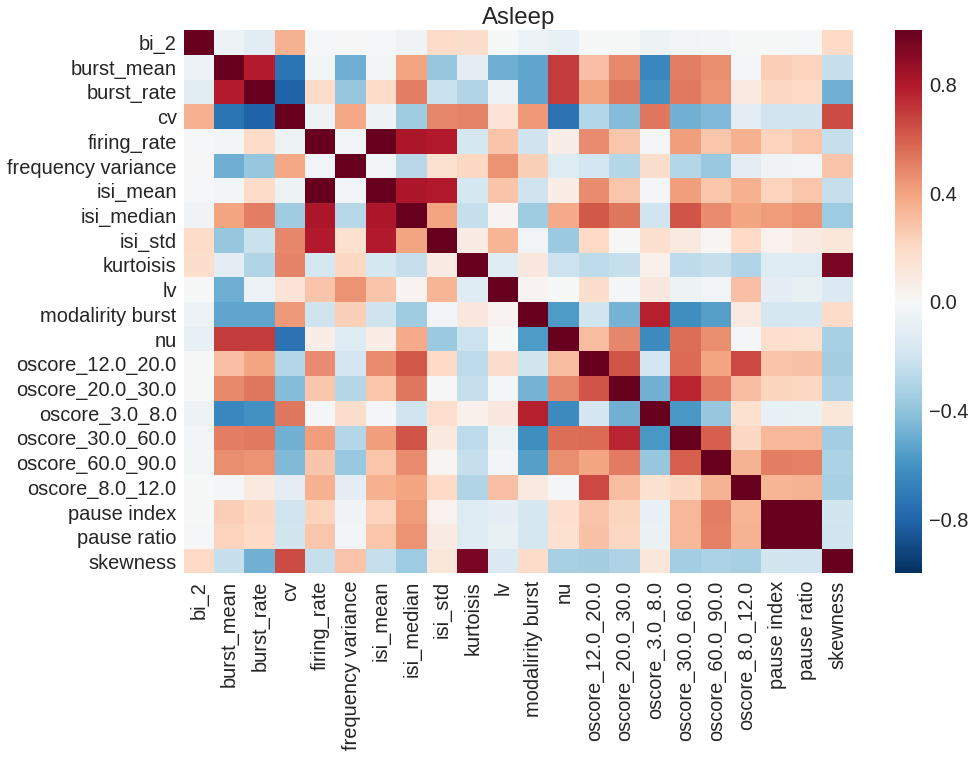

In [62]:
plt.figure(figsize=(15,10))
sns.heatmap(data_sleep.corr())
plt.title('Asleep')

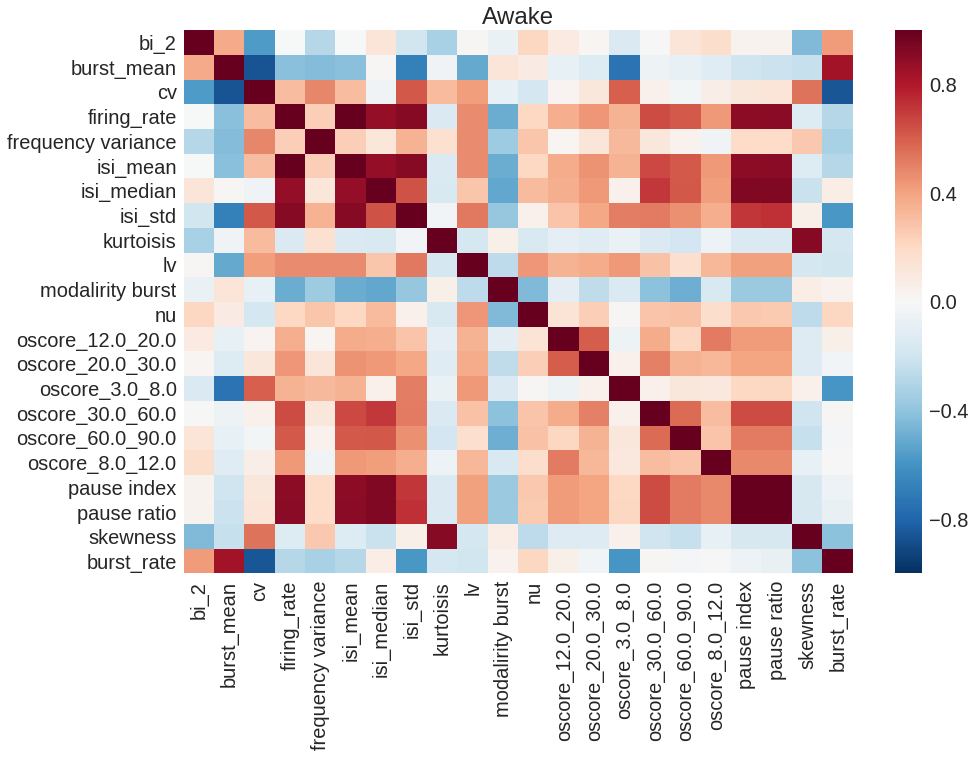

In [63]:
plt.figure(figsize=(15,10))
sns.heatmap(data_awake.corr())
plt.title('Awake')

In [8]:
data_sleep['awake'] = 0
data_awake['awake'] = 1
data = pd.concat([data_sleep, data_awake], ignore_index=True)

In [ ]:
X = data.drop(['type'], axis=1)
y = data['type']


X[:] = scale(X)

In [16]:
data.to_csv('data.csv', index=False)

[('lv', 0.11614731), ('isi_std', 0.087818697), ('frequency variance', 0.072710104), ('oscore_8.0_12.0', 0.070821531), ('nu', 0.065155804)]


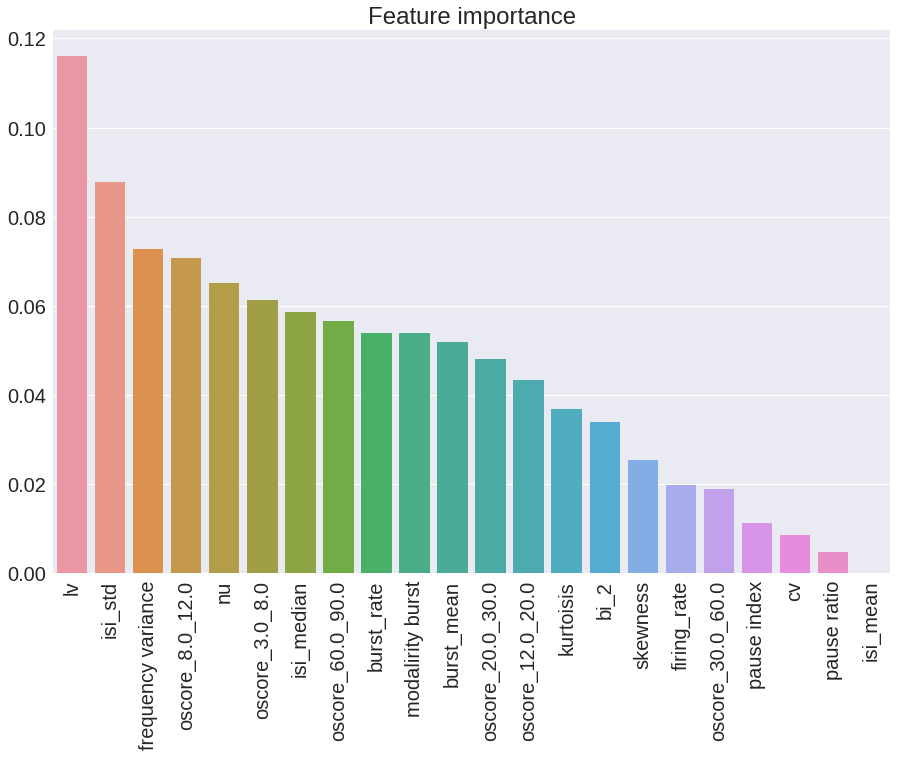

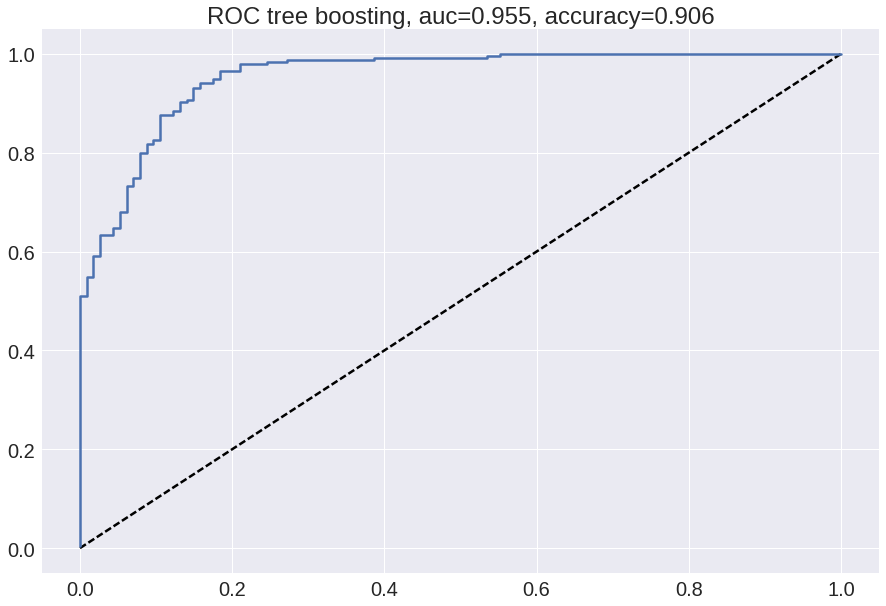

In [65]:
model = xgb.XGBClassifier(learning_rate=0.125, max_depth=3, n_estimators=400)
model.fit(X, y)

fig, ax = plt.subplots(figsize=(15,10))
_ = plt.xticks(rotation=90)

features = sorted(zip(X.columns.values, model.feature_importances_), key = lambda x: x[1], reverse=True)

sns.barplot([f[0] for f in features], [f[1] for f in features])
acc = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
plt.title('Feature importance')


probs = cross_val_predict(model, X, y, method='predict_proba', cv=5)[:,1]
fpr, tpr, _ = roc_curve(y, probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC tree boosting, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))

print features[:5]

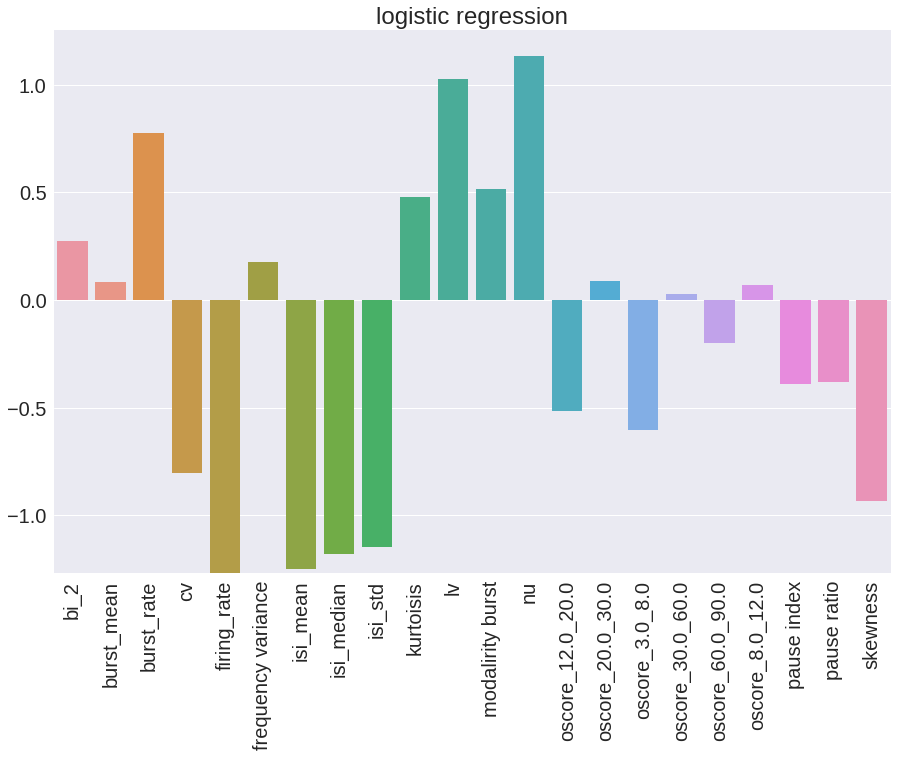

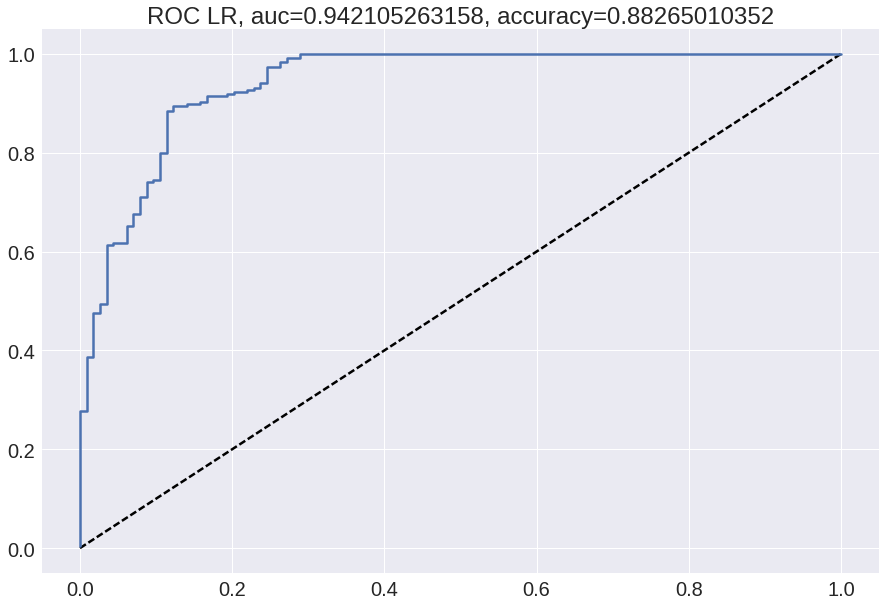

In [66]:
LR = LogisticRegression()
LR.fit(X, y)

plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot(X.columns.values, LR.coef_[0])
acc = np.mean(cross_val_score(LR, X, y, scoring='accuracy', cv=5))
plt.title('logistic regression')

probs = cross_val_predict(LR, X, y, method='predict_proba', cv=5)[:,1]
fpr, tpr, _ = roc_curve(y, probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.xticks(rotation=0)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC LR, auc={}, accuracy={}'.format(auc_score, acc))

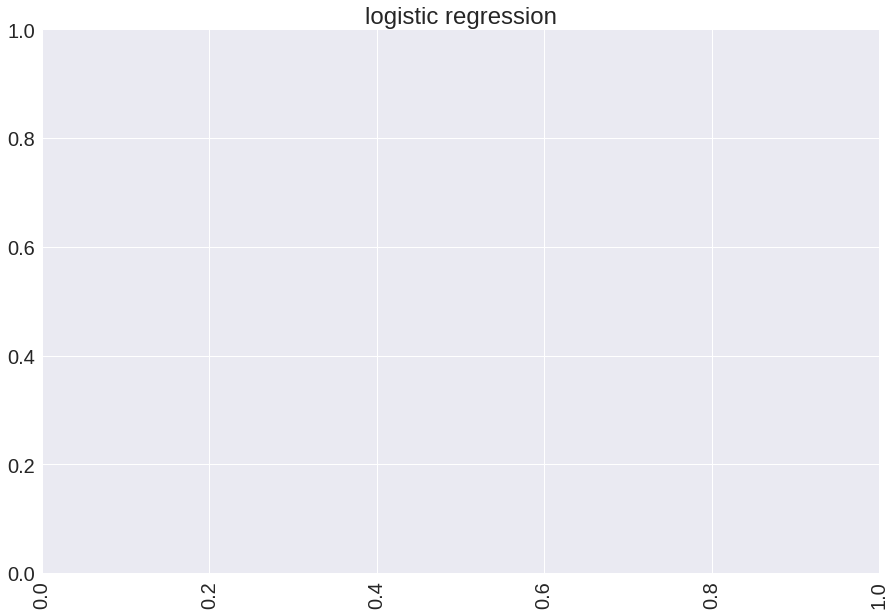

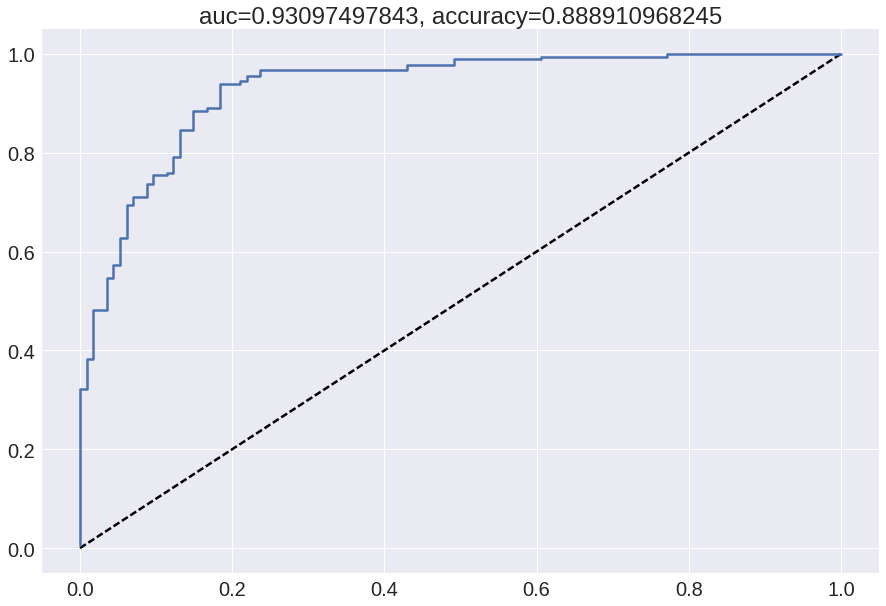

In [20]:
LR = SVC(probability=True)
LR.fit(X, y)

plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
# sns.barplot(X.columns.values, LR.coef_[0])
acc = np.mean(cross_val_score(LR, X, y, scoring='accuracy', cv=5))
plt.title('logistic regression')

probs = cross_val_predict(LR, X, y, method='predict_proba', cv=5)[:,1]
fpr, tpr, _ = roc_curve(y, probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.xticks(rotation=0)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('auc={}, accuracy={}'.format(auc_score, acc))

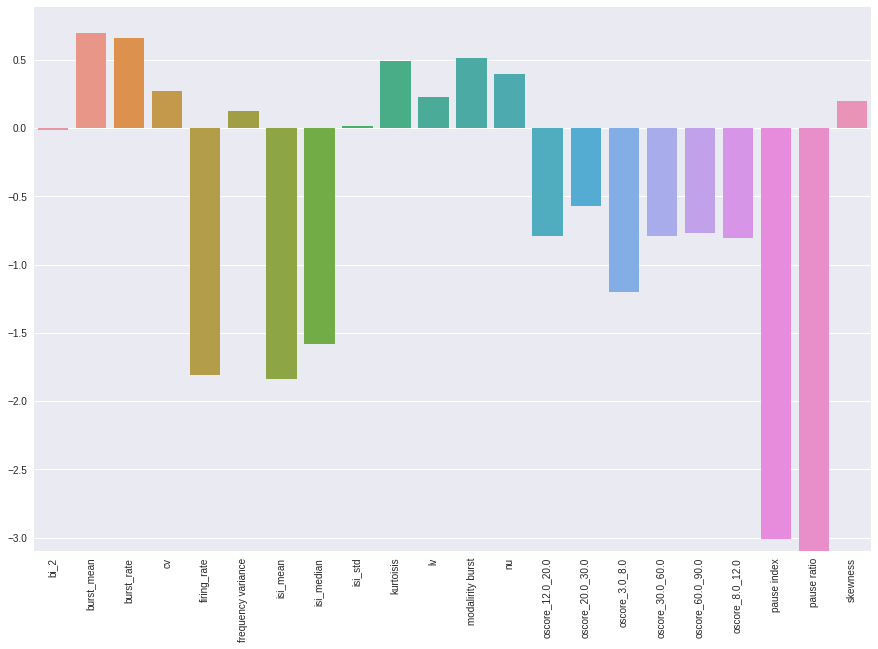

In [16]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot([f[0] for f in res], [f[1] for f in res])

In [26]:
top_features = ['burst_rate',
'cv',
'isi_std',
'lv',
'oscore_3.0_8.0',
'oscore_30.0_60.0']


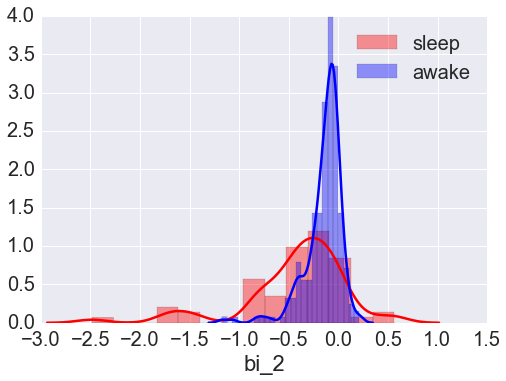

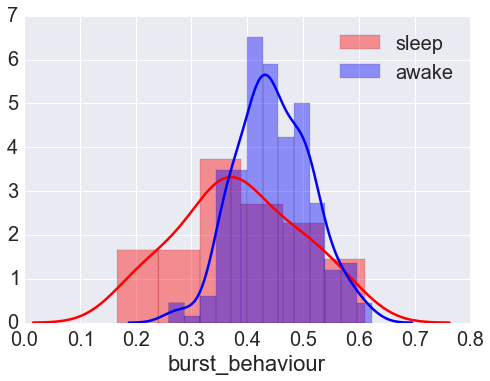

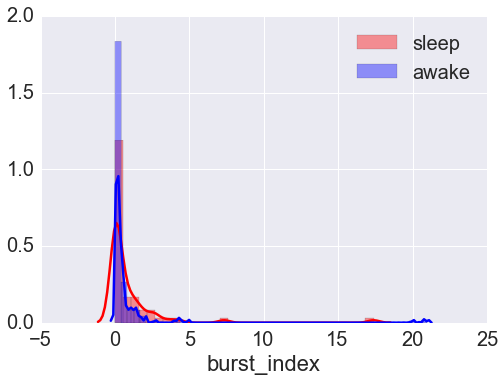

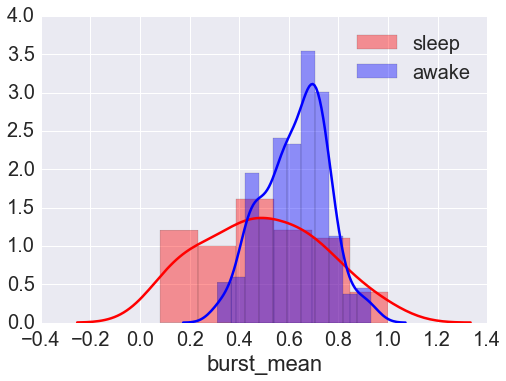

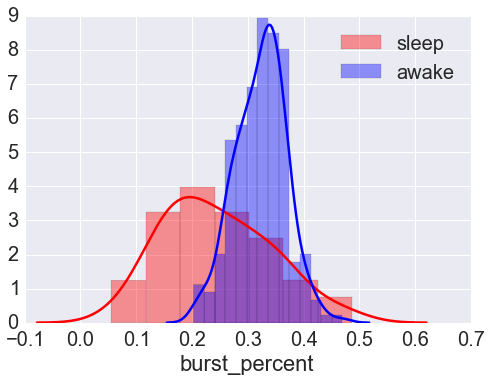

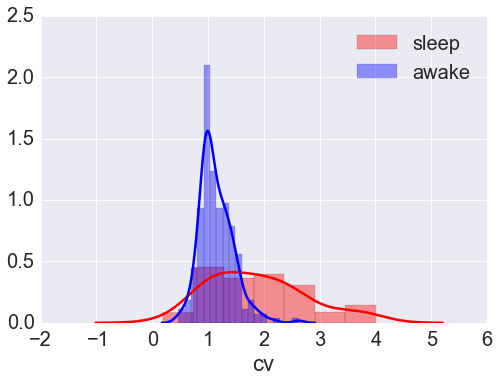

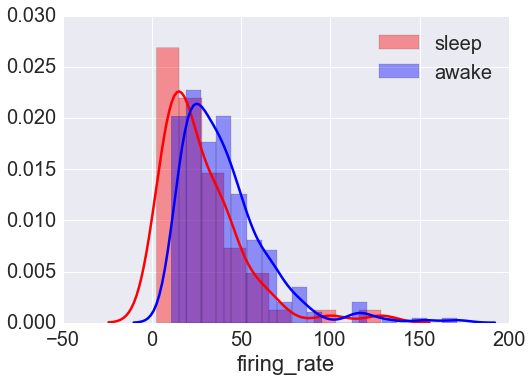

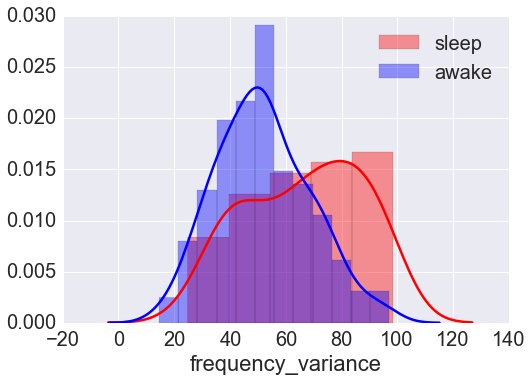

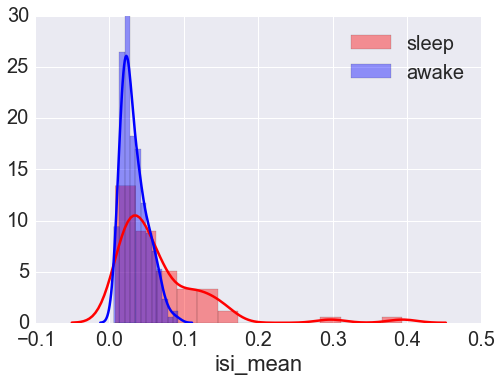

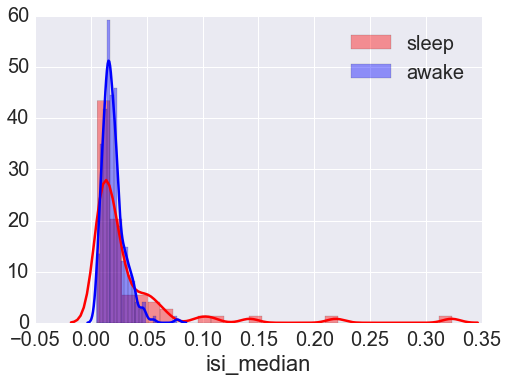

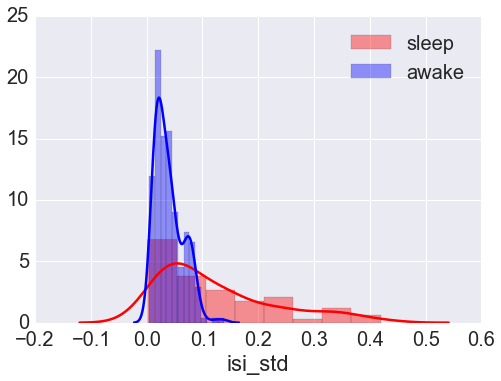

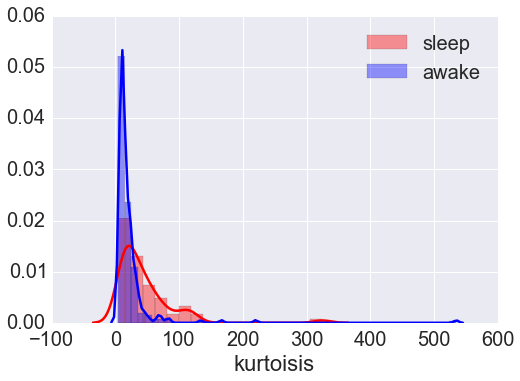

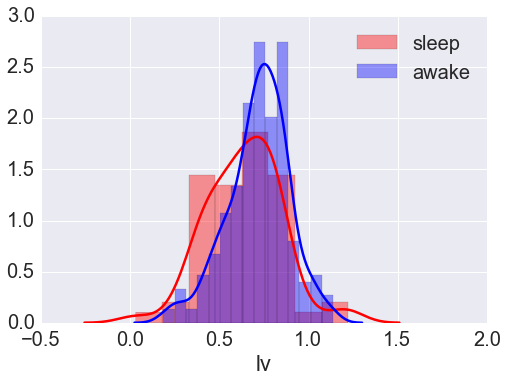

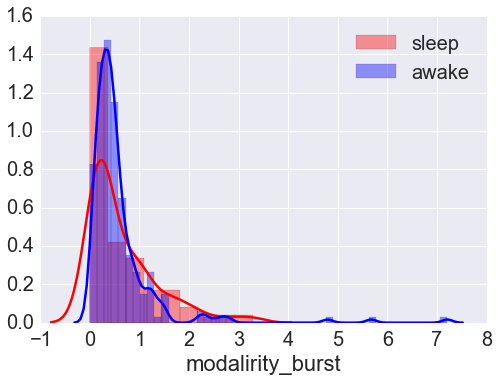

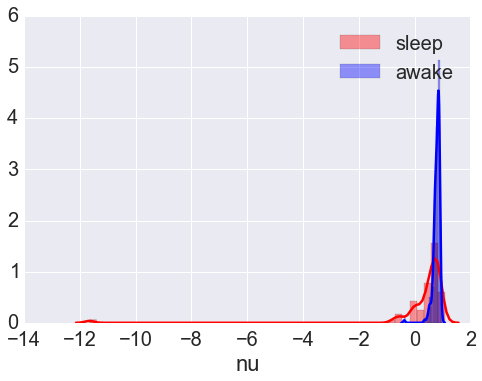

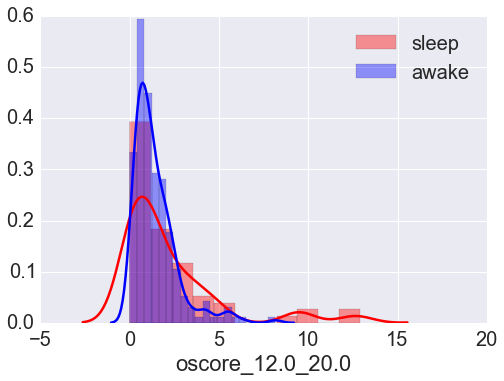

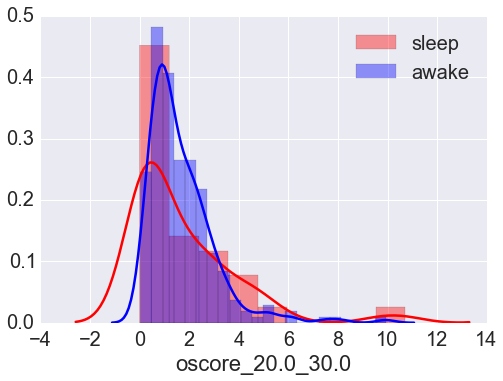

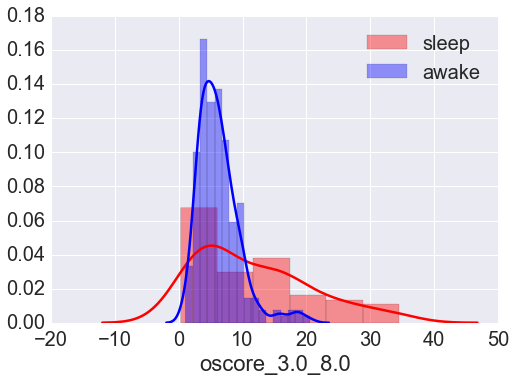

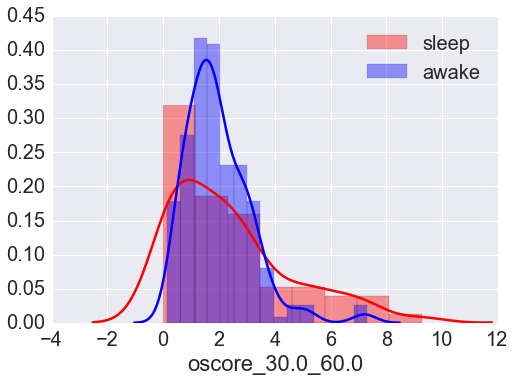

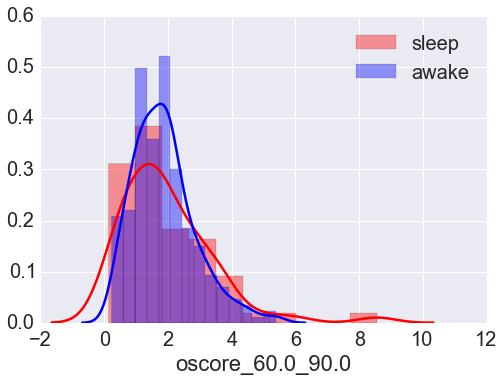

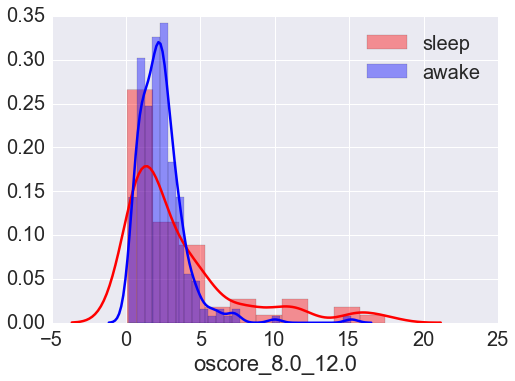

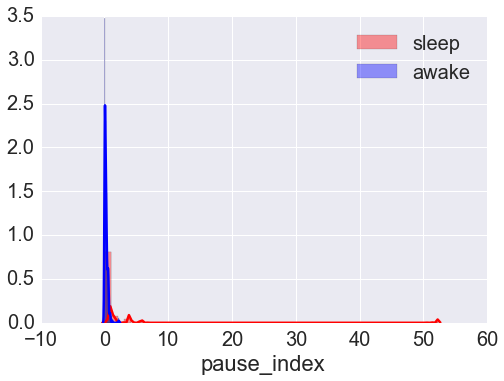

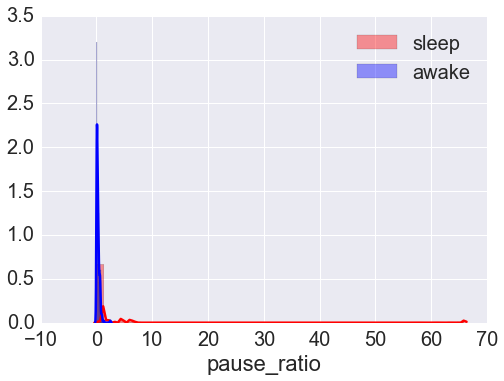

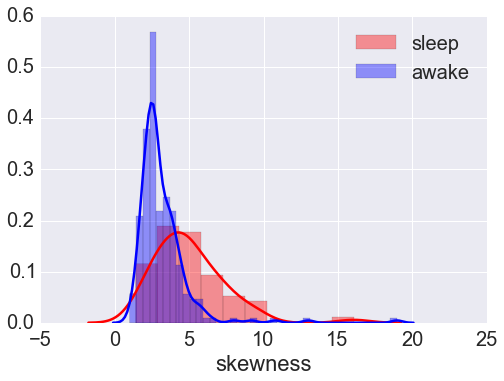

In [17]:
for f in data.drop(['type', 'awake'], axis=1).columns.values:
    plt.figure()
    sns.distplot(data_sleep[f], color='red', label='sleep')
    sns.distplot(data_awake[f], color='blue', label='awake')
    plt.legend()

In [44]:
# sns.pairplot(data, hue='type', size=5)

In [57]:
X = data[top_features]
y = data['type']

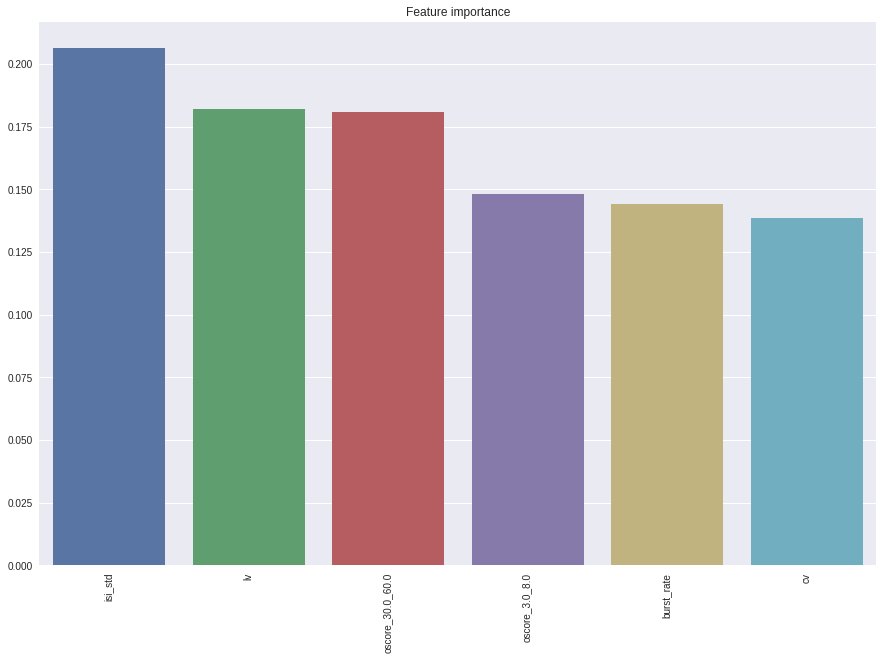

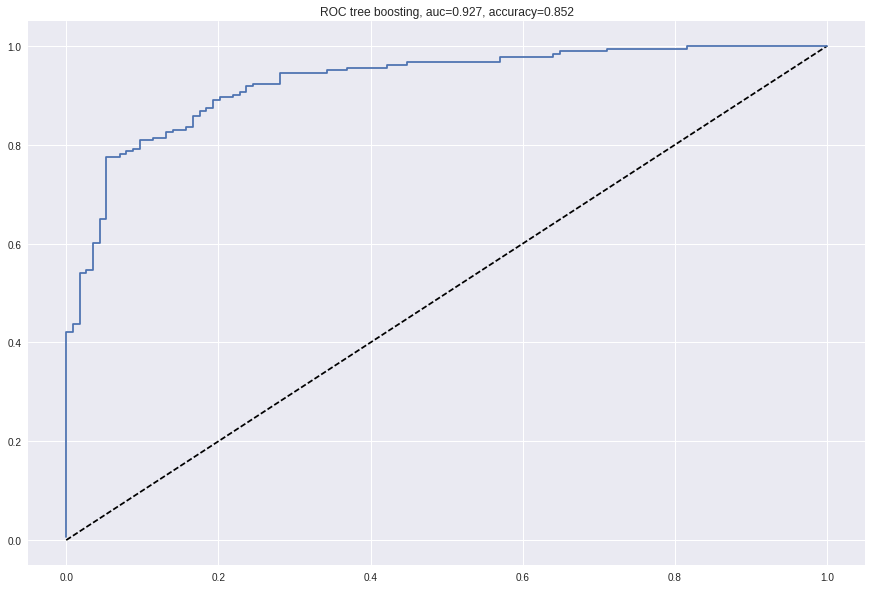

In [58]:
model = xgb.XGBClassifier(learning_rate=0.125, max_depth=3, n_estimators=400)
model.fit(X, y)

fig, ax = plt.subplots(figsize=(15,10))
_ = plt.xticks(rotation=90)

features = sorted(zip(X.columns.values, model.feature_importances_), key = lambda x: x[1], reverse=True)

sns.barplot([f[0] for f in features], [f[1] for f in features])
acc = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
plt.title('Feature importance')


probs = cross_val_predict(model, X, y, method='predict_proba', cv=5)[:,1]
fpr, tpr, _ = roc_curve(y, probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC tree boosting, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))

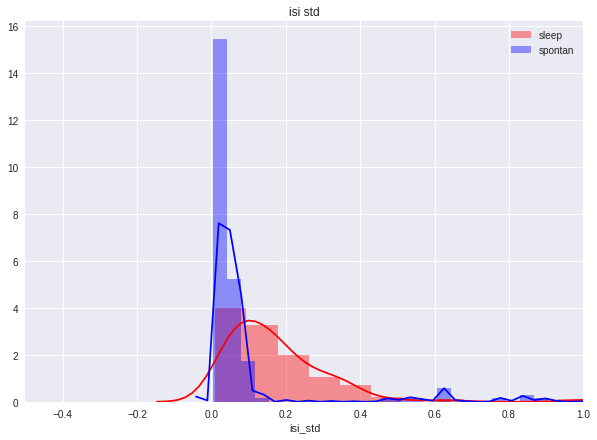

In [22]:
f = plt.figure(figsize=(10,7))
sns.distplot(data_sleep['isi_std'], color='red', label='sleep', bins=25)
sns.distplot(data_awake['isi_std'], color='blue', label='spontan', bins=100)
plt.title('isi std')
plt.xlim(-0.5, 1.)
plt.legend()

In [18]:
data_sleep